In [ ]:
%pip install pandas matplotlib tensorflow scikit-learn keras numpy

In [ ]:
# check if the data is available in the path of './data/'
import os
if 'kaggle' in os.listdir('/'):
    print('Kaggle environment')
    data_path = '/kaggle/input/predict-student-performance-from-game-play/'
else:
    data_path = './data/'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Background

### Features
* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

### The labels
* The label rows have two columns, `session_id` and `correct`
* The `session_id` column format as `<session_id>_q<question #>`. Each session will have 18 rows, representing 18 questions.
* The `correct` column have the value 1 or 0 for all 18 questions for each session in the training set


## Data preprocessing

In [4]:
import pandas as pd
train_data = pd.read_csv(data_path + "train.csv")
train_data.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
# Load the train labels
train_labels = pd.read_csv(data_path + "train_labels.csv")
train_labels.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
# The label rows are identified with <session_id>_q<question #>. 
# Each session will have 18 rows, representing 18 questions.
# The label is the correct value for answer of the question.
# Extract the session_id and question number from the label rows.
train_labels[['session_id', 'question']] = train_labels['session_id'].str.split('_q', expand=True)
train_labels.head()

,session_id,correct,question
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


### Visualizing the labels

<Axes: xlabel='correct'>

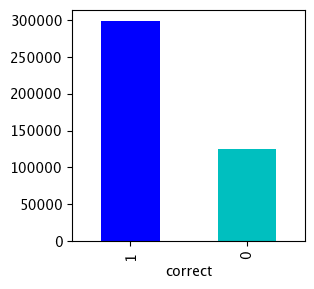

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plot_df = train_labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

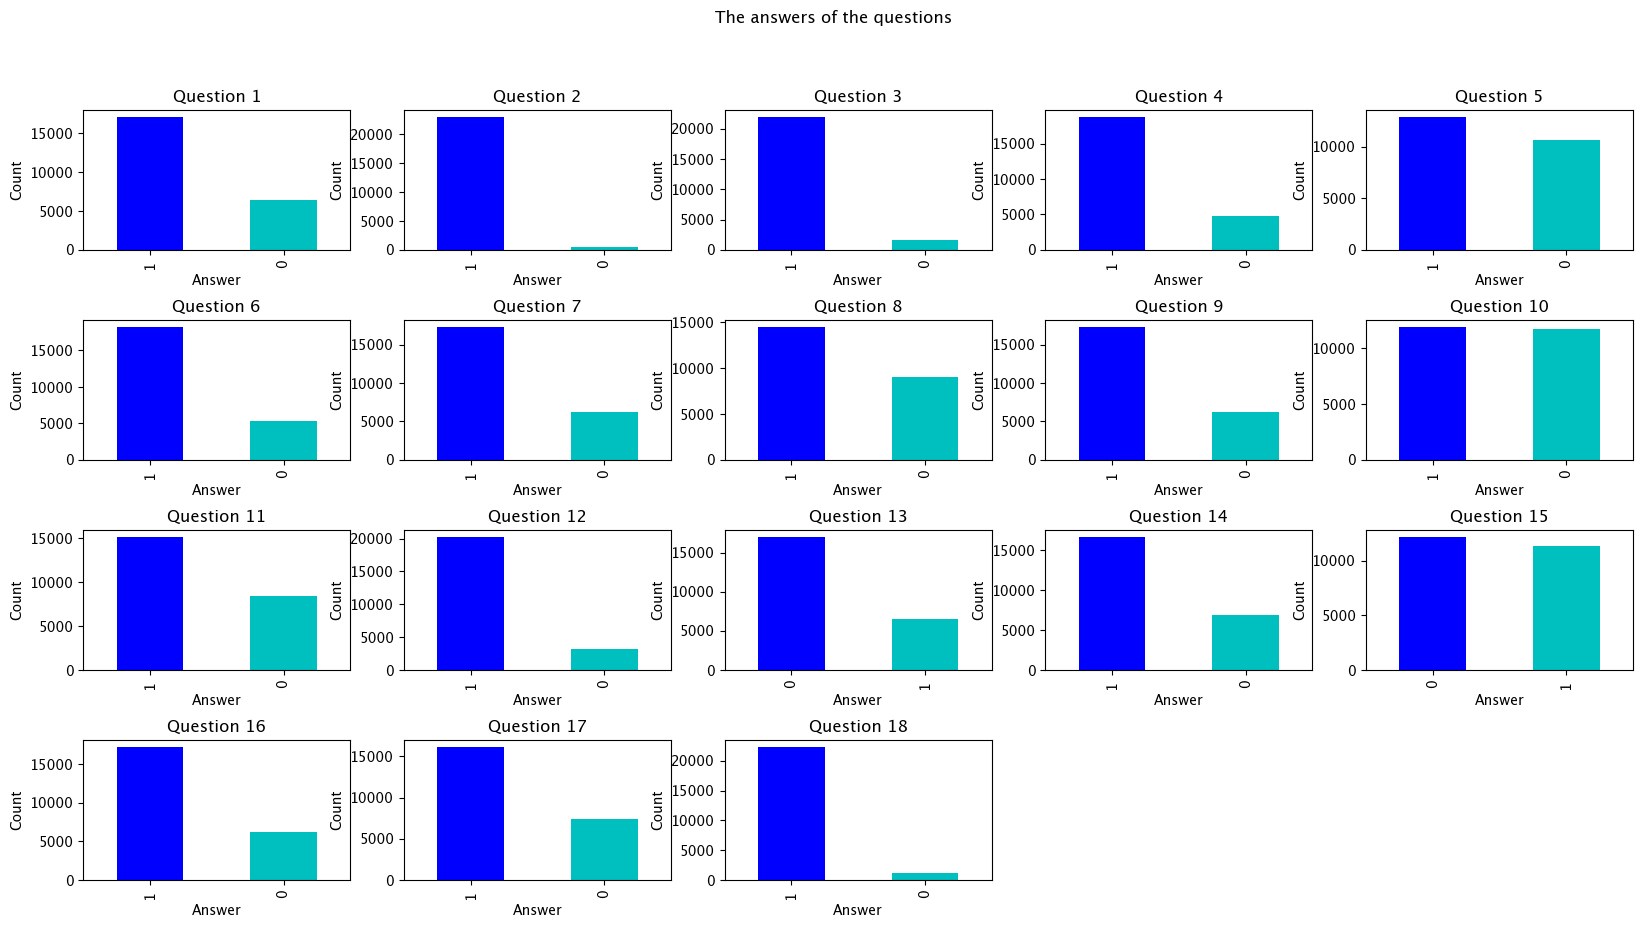

In [8]:
# Show the distribution of the answers of the questions in the train labels in 4 row, 5 columns
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('The answers of the questions')
for i in range(18):
    plt.subplot(4, 5, i+1)

    # filter data and plot ticker on the subplot axis
    plot_df = train_labels.loc[train_labels['question'] == str(i+1)]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(kind="bar", color=['b', 'c'])
    
    plt.title('Question ' + str(i+1))
    plt.xlabel('Answer')
    plt.ylabel('Count')

## Feature engineering

In [9]:
train_data.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,2.629695e+07,2.629695e+07,2.629695e+07,2.629695e+07,564544.000000,2.422367e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.002244e+06,2.629695e+07,2.629695e+07,2.629695e+07
mean,2.113249e+16,6.445102e+02,4.016694e+06,1.219169e+01,3.166559,-5.490579e+01,-1.162119e+02,4.584098e+02,3.855860e+02,3.471003e+03,1.370037e-01,1.202047e-01,9.293778e-01
std,5.712953e+14,5.457880e+02,3.127032e+07,6.497789e+00,2.063291,5.202926e+02,2.184710e+02,2.479389e+02,1.298166e+02,4.602024e+05,3.438513e-01,3.252008e-01,2.561926e-01
min,2.009031e+16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181623e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.101022e+16,2.880000e+02,4.397000e+05,6.000000e+00,1.000000,-3.528395e+02,-2.127183e+02,2.690000e+02,3.040000e+02,9.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.104021e+16,5.950000e+02,1.014801e+06,1.300000e+01,3.000000,-1.116280e+01,-9.760534e+01,4.470000e+02,3.970000e+02,4.190000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.110052e+16,8.960000e+02,1.747040e+06,1.800000e+01,5.000000,2.966515e+02,2.268786e+01,6.630000e+02,4.710000e+02,1.266000e+03,0.000000e+00,0.000000e+00,1.000000e+00
max,2.210022e+16,2.047300e+04,1.988607e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
NUM_FEATURES = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']
BOOL_FEATURES = ['fullscreen', 'hq', 'music']
CATEGORICAL_FEATURES = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid', 'text']

In [11]:
# Check the unique values of the categorical features
for feature in CATEGORICAL_FEATURES:
    print(feature, train_data[feature].unique().shape)


event_name (11,)
name (6,)
fqid (129,)
room_fqid (19,)
text_fqid (127,)
text (598,)
